In [10]:
using CSV, DataFrames, Plots, Statistics, JuMP, Gurobi, StatsBase

In [11]:
pollution = DataFrame(CSV.File("Data/pollution_location.csv"))
pollution_xy = pollution[:,1:2]|>Matrix
sensors = DataFrame(CSV.File("Data/sensors_location.csv"))
sensors_xy = sensors[:,1:2]|>Matrix;

In [12]:
lat_to_km = [111, 92]
lat_diff = (pollution_xy[:,1].-sensors_xy[:,1]').*lat_to_km[1]
long_diff = (pollution_xy[:,2].-sensors_xy[:,2]').*lat_to_km[2]

dist_matrix = sqrt.(lat_diff.^2 + long_diff.^2)';
rows_to_keep = findall(row -> any(iszero, row), eachrow(dist_matrix))
dist_matrix = dist_matrix[rows_to_keep, :]
sensors_xy = sensors_xy[rows_to_keep, :];

In [13]:
q = pollution.AIQ
r = 2
d = (dist_matrix.<=r)
n, m = size(dist_matrix)

(1780, 7107)

In [14]:
q_sen = (dist_matrix.==0) * q
function loss(x, q, k)
    x = round.(x)
    d = 1 ./(dist_matrix .+ 10 .*(1 .-x) .* maximum(dist_matrix) .+ 1)
    dq = d .* q_sen
    q_pred = zeros(size(q))
    for j = 1:size(q, 1)
        indices = partialsortperm(d[:,j], 1:k, rev=true)
        if d[indices[1], j]==1
            q_pred[j] = q_sen[indices[1]]
        else
            q_pred[j] = sum(dq[indices, j].*x[indices])/sum(d[indices, j].*x[indices])
        end
    end
    return sum((q_pred - q).^2)/sum(q.^2)
end

loss (generic function with 1 method)

In [15]:
function model1a()
    model = Model(Gurobi.Optimizer);
    set_optimizer_attribute(model, "TimeLimit", 10);
    
    @variable(model, x[1:n], Bin) #Whether we put a sensor at spot i
    @variable(model, y[1:m].<=1) #Whether spot j is covered
    
    @constraint(model, y'.<= x'*d)
    @constraint(model, sum(x)<=348) # Check this number
    
    
    @objective(model, Max, sum(y.*q))
    optimize!(model)
    return value.(x), value.(y)
end
x, y = model1a()
sum(x)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-08-18
Set parameter TimeLimit to value 10
Set parameter TimeLimit to value 10
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 7108 rows, 8887 columns and 28036 nonzeros
Model fingerprint: 0x73322a36
Variable types: 7107 continuous, 1780 integer (1780 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e+00, 9e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+02, 3e+02]
Found heuristic solution: objective -0.0000000
Presolve removed 274 rows and 275 columns
Presolve time: 0.03s
Presolved: 6834 rows, 8612 columns, 27334 nonzeros
Variable types: 0 continuous, 8612 integer (8612 binary)
Found heuristic solution: objective 94498.989800

Root relaxation: objective 1.765919e+05, 18945 iterations, 0.32 seconds

348.0

In [24]:
pollution_xy

7107×2 Matrix{Float64}:
 33.7082  -118.287
 33.7191  -118.323
 33.7191  -118.314
 33.7191  -118.305
 33.7191  -118.296
 33.7191  -118.287
 33.7191  -118.251
 33.73    -118.35
 33.73    -118.341
 33.73    -118.332
 33.73    -118.323
 33.73    -118.314
 33.73    -118.305
  ⋮       
 34.7626  -118.035
 34.7626  -118.026
 34.7626  -118.017
 34.7626  -118.008
 34.7735  -118.278
 34.7735  -118.269
 34.7735  -118.26
 34.7735  -118.251
 34.7735  -118.242
 34.7735  -118.233
 34.7735  -118.224
 34.7735  -118.215

In [50]:
sensors = sensors_xy[x .== 1, :]
sensors
minimum(sensors[:, 1])

33.729988175426364

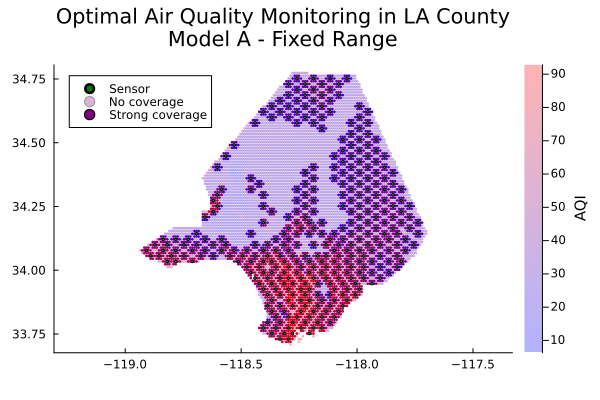

In [59]:
sensors = sensors_xy[x .== 1, :]

scatter(pollution_xy[:, 2], pollution_xy[:, 1], 
    marker_z=q, 
    color=cgrad([:blue, :red]), 
    alpha= .3 .+ 0.7 .* y ,
    markersize=1.5, 
    shape=:circle,  
    markerstrokewidth=0,
    label="",
    ratio = 1.1,
    colorbar=true, colorbar_title = "AQI", legend=:topleft, axis = true, grid = false,
    )

scatter!(
        sensors[:, 2], sensors[:, 1],  
        color="green",
        markersize = 1.5, 
        label = "Sensor"
    )

scatter!([NaN], [NaN], alpha = 0.3, color = :purple, shape = :circle, label = "No coverage")
scatter!([NaN], [NaN], alpha = 1.0, color = :purple, shape = :circle, label = "Strong coverage")


# Add a title with better formatting
title!("Optimal Air Quality Monitoring in LA County\nModel A - Fixed Range")

In [18]:
loss(x, q, 5)

0.03451924004711032